In [1]:
from keras import Input, layers, backend, Model, losses, datasets, models, metrics, optimizers, initializers
from keras.regularizers import l2
from keras.utils import Sequence
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math

Path = "/home/ug-ml/felix-ML/VAE_000/Data/Data" #Folder containing Training Validation and Test

In [2]:
def gen_paths_fromfile(Path):
    Paths = []
    with open(Path) as textFile:
        lines = [line.split() for line in textFile]
    for i in lines:
        Paths.append(i[0])
        
    Paths = np.array(Paths, dtype = "object")
    return(Paths)

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        """Here self.x is a list of paths to .npy input files. self.y is a
        corresponding list of paths to .npy output files."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        #print(np.array([np.load(file_name) for file_name in batch_x]).shape, np.array([np.load(file_name) for file_name in batch_y]).shape)
        return np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_x]), np.array([np.reshape(np.load(file_name), (128, 128, 1)) for file_name in batch_y])


    
def MeanSquare(Image_1, Image_2): #Shape N by N
    ms = (np.mean(np.square(Image_1 - Image_2)))
    return(ms)


def ZMCC_loss(Image1, Image2):
    sd1 = np.std(Image1)
    mean1 = np.mean(Image1)
    
    sd2 = np.std(Image2)
    mean2 = np.mean(Image2)
    
    zmcc = 1 - (1 / (128 * 128 * sd1 * sd2)) * np.sum((Image1 - mean1) * (Image2 - mean2))
    return(zmcc)


In [21]:
vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/DataAllInOne_Normalised/VAE_000_2/Models/VAE_000_Normalised_0point1_HPopt_1")
vae.summary()

batch_size = 1

basepath = "/home/ug-ml/felix-ML/VAE_000/DataAllInOne_Normalised/VAE_000_2/FilePaths/"

TrainingPathsInput = gen_paths_fromfile(basepath + "TrainingInput_0point1.txt")
ValidationPathsInput = gen_paths_fromfile(basepath + "ValidationInput_0point1.txt")
TestPathsInput = gen_paths_fromfile(basepath + "TestInput_0point1.txt")

TrainingPathsOutput = gen_paths_fromfile(basepath + "TrainingOutput_0point1.txt")
ValidationPathsOutput = gen_paths_fromfile(basepath + "ValidationOutput_0point1.txt")
TestPathsOutput = gen_paths_fromfile(basepath + "TestOutput_0point1.txt")


def FindLoss(Paths_in, Paths_out):
    All_loss = np.zeros(len(Paths_in), dtype = np.float32)
    for i in range(0, len(Paths_in)):
        x = np.load(Paths_in[i])
        y = np.load(Paths_out[i])

        a = np.reshape(vae(np.reshape(x, (1, 128, 128, 1))), (128, 128))
        zmcc = ZMCC_loss(a,y)
        All_loss[i] = zmcc
    return(All_loss)

All_val_loss = FindLoss(ValidationPathsInput, ValidationPathsOutput)
All_test_loss = FindLoss(TestPathsInput, TestPathsOutput)

np.save("/home/ug-ml/tmp_git/FelixML_New/data_analysis/generation/Graphs/RawLoss/VAE_val_loss", All_val_loss)
np.save("/home/ug-ml/tmp_git/FelixML_New/data_analysis/generation/Graphs/RawLoss/VAE_test_loss", All_test_loss)

Model: "vae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  3051835   
_________________________________________________________________
decoder (Decoder)            multiple                  1939649   
_________________________________________________________________
total_loss (Mean)            multiple                  2         
_________________________________________________________________
reconstruction_loss (Mean)   multiple                  2         
_________________________________________________________________
kl_loss (Mean)               multiple                  2         
Total params: 4,991,490
Trainable params: 4,991,484
Non-trainable params: 6
_________________________________________________________________


In [14]:
print(np.mean(All_val_loss))
print(np.mean(All_test_loss))

0.10504241
0.097126685


In [16]:
vae = models.load_model("/home/ug-ml/felix-ML/VAE_000/DataAllInOne_Normalised/VAE_000_2/Models/VAE_000_Normalised_0point1_HPopt_1")
vae.summary()

batch_size=32
data_path = "/home/ug-ml/felix-ML/VAE_000/DataAllInOne_Normalised/VAE_000_2/FilePaths/"

ValidationPathsInput = gen_paths_fromfile(data_path + "ValidationInput_0point1.txt")
ValidationPathsOutput = gen_paths_fromfile(data_path + "ValidationOutput_0point1.txt")
val_seq = FelixSequence(ValidationPathsInput, ValidationPathsOutput, batch_size)
import time
start = time.time()
#c = 0
for x, y in val_seq:
    #c += 32
    reconstruction = vae(x)
end = time.time()
print(end - start)
print(c)


Model: "vae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  3051835   
_________________________________________________________________
decoder (Decoder)            multiple                  1939649   
_________________________________________________________________
total_loss (Mean)            multiple                  2         
_________________________________________________________________
reconstruction_loss (Mean)   multiple                  2         
_________________________________________________________________
kl_loss (Mean)               multiple                  2         
Total params: 4,991,490
Trainable params: 4,991,484
Non-trainable params: 6
_________________________________________________________________
0.5982141494750977
544


In [15]:
def WhichCifs(Paths):
    CifBasePath = Paths[0].split("Data/AllData")[0] + "CifFolder/"
    CifPaths = []
    for i in range(0, int(len(Paths))):
        crystal_i = int(Paths[i].split("/")[-2])
        CifPaths.append(CifBasePath + str(crystal_i) + ".cif")
    
    return(CifPaths)

    

def LoadAllCif(Path):
    CifInfo = []
    for i in Path:
        with open(i) as textFile:
            lines = [line.split() for line in textFile]

        for j in lines:
            for k in range(0, len(j)):
                if(j[k] == "_cell_length_a"):
                    lattice_a = float(j[k + 1].split("(")[0])
                    print(lattice_a)
                
                if(j[k] == "_symmetry_Int_Tables_number"):
                    spacegroup = j[k+1]
                    print(spacegroup)
                    print("")
                    CifInfo.append([lattice_a, spacegroup])
                    break
    return(CifInfo)

def IsInList(List, Value):
    if(len(List) == 0):
        return(False)
    else:
        for i in List:
            if(i == Value):
                return True
    return False

def ArgInList(List, Value):
    for i in range(0, len(List)):
        if(List[i] == Value):
            return(i)
    return(None)


def SpaceGroupInfo(CifInfo):
    ListSpaceGroup = []
    for i in CifInfo:
        spacegroup = i[1]
        if(IsInList(ListSpaceGroup, spacegroup) == False):
            ListSpaceGroup.append(spacegroup)
    ListSpaceGroup = sorted(ListSpaceGroup)
    NumberSpaceGroup = len(ListSpaceGroup)
    HistSpaceGroup = np.zeros(NumberSpaceGroup, dtype = np.int)
    
    for i in CifInfo:
        spacegroup = i[1]
        arg = 0
        for j in range(0, NumberSpaceGroup):
            if(ListSpaceGroup[j] == spacegroup):
                arg = j
                break
        HistSpaceGroup[j]+=1
        
    
    return(ListSpaceGroup, HistSpaceGroup)

def LatticeSizeInfo(CifInfo):
    minsize = np.inf
    maxsize = -np.inf
    for i in CifInfo:
        if(i[0] < minsize):
            minsize = i[0]
        elif(i[0] > maxsize):
            maxsize = i[0]
            
    NumberLattice = int(np.floor(maxsize) - np.floor(minsize) + 1)
    LatticeHist = np.zeros(NumberLattice, dtype = np.int)
    for i in CifInfo:
        index = int(np.floor(i[0]) - np.floor(minsize))
        LatticeHist[index]+=1
    
    return([minsize, maxsize], LatticeHist)



CifPaths_test = WhichCifs(TestPathsInput)
CifInfo_test = LoadAllCif(CifPaths_test)

ListSpaceGroup_test, HistSpaceGroup_test = SpaceGroupInfo(CifInfo_test)
LatticeRange_test, LatticeHist_test = LatticeSizeInfo(CifInfo_test)


CifPaths_val = WhichCifs(ValidationPathsInput)
CifInfo_val = LoadAllCif(CifPaths_val)

ListSpaceGroup_val, HistSpaceGroup_val = SpaceGroupInfo(CifInfo_val)
LatticeRange_val, LatticeHist_val = LatticeSizeInfo(CifInfo_val)

24.92
203

16.3782
197

24.982
203

24.872
203

24.947
203

15.085
203

24.934
203

16.7631
203

15.482
204

10.184
197

7.9951
204

8.2055
204

13.783
197

7.275
204

7.745
204

7.738
204

9.306
204

9.23
204

9.0775
204

10.0194
204

10.0204
204

9.137
204

8.6889
204

13.933
204

7.6761
204

9.2665
204

13.6872
197

7.483
204

7.4124
204

7.4848
204

9.107
204

7.6933
204

8.173
205

6.4394
205

8.245
205

11.93
205

12.4
205

6.687
205

12.2491
205

12.314
205

9.5859
205

11.335
205

10.22
205

10.8522
205

9.7248
205

18.0294
197

12.3738
205

12.8542
205

12.8417
205

17.6
206

12.489
206

10.6038
206

10.16
206

10.678
206

10.7716
206

10.8056
206

10.4691
206

10.8813
206

9.8349
206

10.6452
206

6.363
198

10.7917
206

8.898
198

26.978
209

8.181
212

4.534
198

8.952
198

8.4096
212

8.96
212

11.24
213

11.884
213

6.43
213

13.7995
213

6.9352
213

6.424
213

9.9679
214

12.4504
214

6.7114
198

7.7644
215

7.8773
215

7.9275
215

7.8416
215

4.6764
198

8.685
215

7.83

In [16]:
def BinLattice(Diff, LatticeRange, LatticeHist, CifInfo): 
    min_lattice = math.floor(LatticeRange[0])
    max_lattice = math.floor(LatticeRange[1])
    
    NoBins = max_lattice - min_lattice + 1
    
    bin_size = (max_lattice - min_lattice) / NoBins
    Bin_values = ((np.arange(NoBins, dtype = np.float32) / (NoBins - 1))) * (max_lattice - min_lattice) + min_lattice
    
    Bin_Diff = np.zeros(NoBins, dtype = np.float32)
    Bin_Acc = np.zeros(NoBins, dtype = np.float32)
    
    for i in range(0, len(Diff)):
        print(i, len(Diff))
        index = int(np.floor(CifInfo[i][0]) - min_lattice)
            
        Bin_Diff[index]+=Diff[i]
    
    for i in range(0, NoBins):
        Bin_Diff[i] = Bin_Diff[i] / LatticeHist[i]
    
    return(Bin_Diff, Bin_values)

BinLattice_Diff_val, BinLattice_values_val = BinLattice(All_val_loss, LatticeRange_val, LatticeHist_val, CifInfo_val)
BinLattice_Diff_test, BinLattice_values_test = BinLattice(All_test_loss, LatticeRange_test, LatticeHist_test, CifInfo_test)

0 522
1 522
2 522
3 522
4 522
5 522
6 522
7 522
8 522
9 522
10 522
11 522
12 522
13 522
14 522
15 522
16 522
17 522
18 522
19 522
20 522
21 522
22 522
23 522
24 522
25 522
26 522
27 522
28 522
29 522
30 522
31 522
32 522
33 522
34 522
35 522
36 522
37 522
38 522
39 522
40 522
41 522
42 522
43 522
44 522
45 522
46 522
47 522
48 522
49 522
50 522
51 522
52 522
53 522
54 522
55 522
56 522
57 522
58 522
59 522
60 522
61 522
62 522
63 522
64 522
65 522
66 522
67 522
68 522
69 522
70 522
71 522
72 522
73 522
74 522
75 522
76 522
77 522
78 522
79 522
80 522
81 522
82 522
83 522
84 522
85 522
86 522
87 522
88 522
89 522
90 522
91 522
92 522
93 522
94 522
95 522
96 522
97 522
98 522
99 522
100 522
101 522
102 522
103 522
104 522
105 522
106 522
107 522
108 522
109 522
110 522
111 522
112 522
113 522
114 522
115 522
116 522
117 522
118 522
119 522
120 522
121 522
122 522
123 522
124 522
125 522
126 522
127 522
128 522
129 522
130 522
131 522
132 522
133 522
134 522
135 522
136 522
137 522
138 52

/home/ug-ml/felix-ML/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


[  2  18  37  32  29  75  66 106  27  38  18  14  10   7   6   3   4   1
   3   1   1  12   9   1   0   0   0   0   1   0   0   0   0   1]


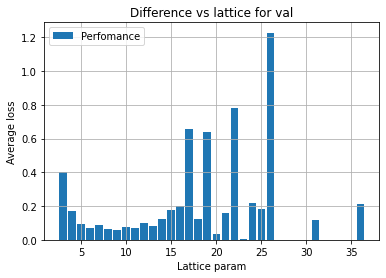

[ 1  4 12 14 26 41 27 51 21 19 10  7  3  2  4  1  2  1  0  0  2  9  2  2
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1]


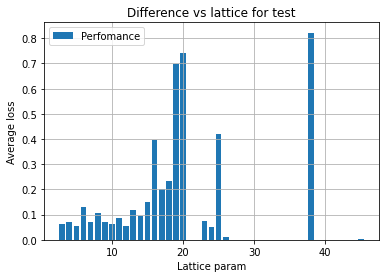

In [22]:
plt.bar(BinLattice_values_val, BinLattice_Diff_val, label = "Perfomance")
print(LatticeHist_val)
plt.xlabel('Lattice param')

plt.ylabel('Average loss')
plt.title('Difference vs lattice for val')
plt.legend()
#plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.show()


plt.bar(BinLattice_values_test, BinLattice_Diff_test, label = "Perfomance")
print(LatticeHist_test)
plt.xlabel('Lattice param')

plt.ylabel('Average loss')
plt.title('Difference vs lattice for test')
plt.legend()
#plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.show()

lattice_path = "/home/ug-ml/tmp_git/FelixML_New/data_analysis/generation/Graphs/LatticeParam/"
np.savetxt(lattice_path + "VAE_BinLattice_values_test_x1", BinLattice_values_test)
np.savetxt(lattice_path + "VAE_BinLattice_Diff_test_y1", BinLattice_Diff_test)
#np.savetxt(lattice_path + "VAE_LatticeHist_test_y2", LatticeHist_test)

In [18]:
def BinSpaceGroup(Diff, ListSpaceGroup, HistSpaceGroup, CifInfo):
    NoBins = len(ListSpaceGroup)
    
    Bin_Diff = np.zeros(NoBins, dtype = np.float32)
    Bin_Acc = np.zeros(NoBins, dtype = np.float32)
    
    for i in range(0, len(Diff)):
        index = ArgInList(ListSpaceGroup, CifInfo[i][1])     
        Bin_Diff[index]+=Diff[i]
    
    for i in range(0, NoBins):
        Bin_Diff[i] = Bin_Diff[i] / HistSpaceGroup[i]
        
    return(Bin_Diff)

BinSG_Diff_val = BinSpaceGroup(All_val_loss, ListSpaceGroup_val, HistSpaceGroup_val, CifInfo_val)
BinSG_Diff_test = BinSpaceGroup(All_test_loss, ListSpaceGroup_test, HistSpaceGroup_test, CifInfo_test)

[ 1  6 14 25 10 18  6  9 15 42 29 32  2 20 16  4 22 35 38 32  3 35  5 22
 13 46 22]


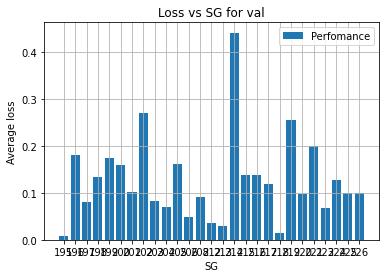

[ 5 11 12  5  6  4 10 21 16 12  1  3  6  2 12 11 22 19  4 19  3 14  9 22
 14]


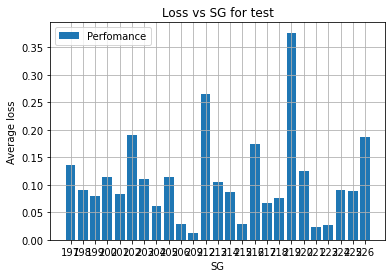

In [26]:
plt.bar(ListSpaceGroup_val, BinSG_Diff_val, label = "Perfomance")
print(HistSpaceGroup_val)
plt.xlabel('SG')

plt.ylabel('Average loss')
plt.title('Loss vs SG for val')
plt.legend()
#plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.show()


plt.bar(ListSpaceGroup_test, BinSG_Diff_test, label = "Perfomance")
print(HistSpaceGroup_test)
plt.xlabel('SG')

plt.ylabel('Average loss')
plt.title('Loss vs SG for test')
plt.legend()
#plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.show()



lattice_path = "/home/ug-ml/tmp_git/FelixML_New/data_analysis/generation/Graphs/SpaceGroup/"
np.savetxt(lattice_path + "VAE_ListSpaceGroup_test_x1", ListSpaceGroup_test, fmt='%s')
np.savetxt(lattice_path + "VAE_BinSG_Diff_test_y1", BinSG_Diff_test)
#np.savetxt(lattice_path + "VAE_HistSpaceGroup_test_y2", HistSpaceGroup_test)